In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import optimize
import pymc3 as pm
import theano
import theano.tensor as tt

# configure some basic options
sns.set(style="darkgrid", palette="muted")
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 12, 8
np.random.seed(0)

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.6


In [3]:
#### cut & pasted directly from the fetch_hogg2010test() function
## identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(np.array([[1, 201, 592, 61, 9, -0.84],
                                 [2, 244, 401, 25, 4, 0.31],
                                 [3, 47, 583, 38, 11, 0.64],
                                 [4, 287, 402, 15, 7, -0.27],
                                 [5, 203, 495, 21, 5, -0.33],
                                 [6, 58, 173, 15, 9, 0.67],
                                 [7, 210, 479, 27, 4, -0.02],
                                 [8, 202, 504, 14, 4, -0.05],
                                 [9, 198, 510, 30, 11, -0.84],
                                 [10, 158, 416, 16, 7, -0.69],
                                 [11, 165, 393, 14, 5, 0.30],
                                 [12, 201, 442, 25, 5, -0.46],
                                 [13, 157, 317, 52, 5, -0.03],
                                 [14, 131, 311, 16, 6, 0.50],
                                 [15, 166, 400, 34, 6, 0.73],
                                 [16, 160, 337, 31, 5, -0.52],
                                 [17, 186, 423, 42, 9, 0.90],
                                 [18, 125, 334, 26, 8, 0.40],
                                 [19, 218, 533, 16, 6, -0.78],
                                 [20, 146, 344, 22, 5, -0.56]]),
                   columns=['id','x','y','sigma_y','sigma_x','rho_xy'])

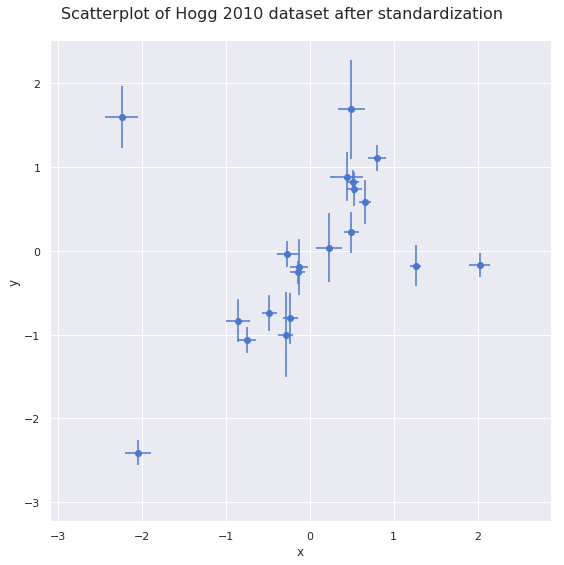

In [4]:
## for convenience zero-base the 'id' and use as index
dfhogg['id'] = dfhogg['id'] - 1
dfhogg.set_index('id', inplace=True)

## standardize (mean center and divide by 1 sd)
dfhoggs = (dfhogg[['x','y']] - dfhogg[['x','y']].mean(0)) / dfhogg[['x','y']].std(0)
dfhoggs['sigma_y'] = dfhogg['sigma_y'] / dfhogg['y'].std(0)
dfhoggs['sigma_x'] = dfhogg['sigma_x'] / dfhogg['x'].std(0)

## create xlims ylims for plotting
xlims = (dfhoggs['x'].min() - np.ptp(dfhoggs['x'])/5
                 ,dfhoggs['x'].max() + np.ptp(dfhoggs['x'])/5)
ylims = (dfhoggs['y'].min() - np.ptp(dfhoggs['y'])/5
                 ,dfhoggs['y'].max() + np.ptp(dfhoggs['y'])/5)

## scatterplot the standardized data
g = sns.FacetGrid(dfhoggs, size=8)
_ = g.map(plt.errorbar, 'x', 'y', 'sigma_y', 'sigma_x', marker="o", ls='')
_ = g.axes[0][0].set_ylim(ylims)
_ = g.axes[0][0].set_xlim(xlims)

plt.subplots_adjust(top=0.92)
_ = g.fig.suptitle('Scatterplot of Hogg 2010 dataset after standardization', fontsize=16)

In [5]:
with pm.Model() as mdl_ols:

    ## Define weakly informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=1)
    b1 = pm.Normal('b1_slope', mu=0, sd=1)

    ## Define linear model
    yest = b0 + b1 * dfhoggs['x']

    ## Use y error from dataset, convert into theano variable
    sigma_y = theano.shared(np.asarray(dfhoggs['sigma_y'],
                            dtype=theano.config.floatX), name='sigma_y')

    ## Define Normal likelihood
    likelihood = pm.Normal('likelihood', mu=yest, sd=sigma_y, observed=dfhoggs['y'])

In [6]:
with mdl_ols:
    ## take samples
    traces_ols = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1_slope, b0_intercept]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 3078.20draws/s]


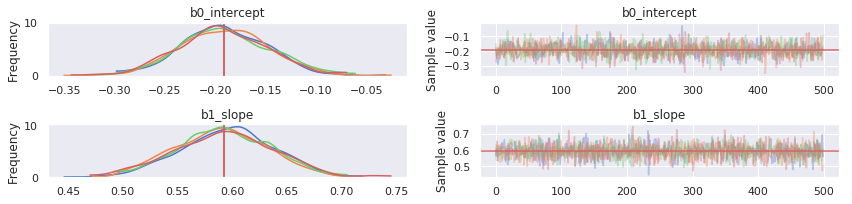

In [8]:
_ = pm.traceplot(traces_ols, figsize=(12, len(traces_ols.varnames)*1.5),
                lines={k: v['mean'] for k, v in pm.summary(traces_ols[-1000:]).iterrows()})

In [27]:
with pm.Model() as mdl_signoise:

    ## Define informative Normal priors to give Ridge regression
    b0 = pm.Normal('b0_intercept', mu=0, sd=1)
    b1 = pm.Normal('b1_slope', mu=0, sd=1)

    ## Define linear model
    yest_in = b0 + b1 * dfhoggs['x']

    ## Define weakly informative priors for the mean and variance of outliers
    yest_out = pm.Normal('yest_out', mu=0, sd=10)
    sigma_y_out = pm.HalfNormal('sigma_y_out', sd=10)

    ## Define Bernoulli inlier / outlier flags according to a hyperprior
    ## fraction of outliers, itself constrained to [0, .5] for symmetry
    frac_outliers = pm.Uniform('frac_outliers', lower=0.0, upper=.5)
    is_outlier = pm.Bernoulli('is_outlier', p=frac_outliers, shape=dfhoggs.shape[0])

    ## Extract observed y and sigma_y from dataset, encode as theano objects
    yobs = theano.shared(np.asarray(dfhoggs['y'], dtype=theano.config.floatX))
    sigma_y_in = np.asarray(dfhoggs['sigma_y'], dtype=theano.config.floatX)

    # Set up normal distributions that give us the logp for both distributions
    inliers = pm.Normal.dist(mu=yest_in, sd=sigma_y_in).logp(yobs)
    outliers = pm.Normal.dist(mu=yest_out, tau=sigma_y_in**2 + sigma_y_out**2).logp(yobs)
    # Build custom likelihood, a potential will just be added to the logp and can thus function
    # like a likelihood that we would add with the observed kwarg.
    pm.Potential('obs', ((1 - is_outlier) * inliers).sum() + (is_outlier * outliers).sum())

In [28]:
with mdl_signoise:
    traces_signoise = pm.sample(5000, tune=25000, init = 'advi+adapt_diag', nuts_kwargs={'target_accept': .97})

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [frac_outliers, sigma_y_out, yest_out, b1_slope, b0_intercept]
>BinaryGibbsMetropolis: [is_outlier]
Sampling 4 chains: 100%|██████████| 120000/120000 [02:44<00:00, 728.72draws/s]


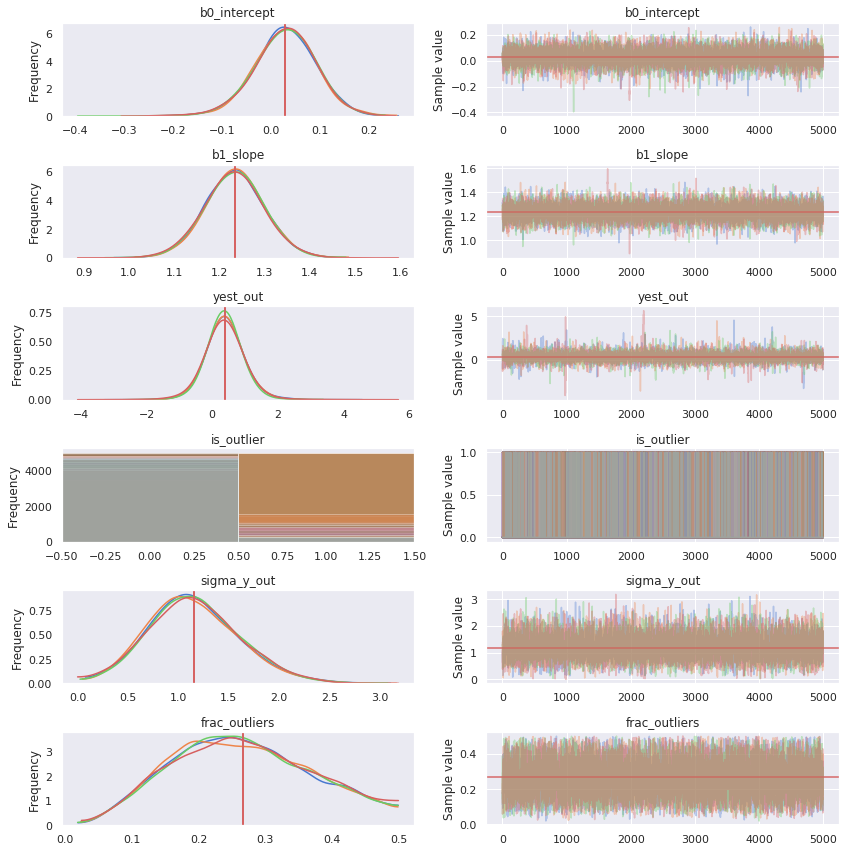

In [29]:
_ = pm.traceplot(traces_signoise, figsize=(12, len(traces_signoise.varnames)*1.5),
            lines={k: v['mean'] for k, v in pm.summary(traces_signoise).iterrows()})

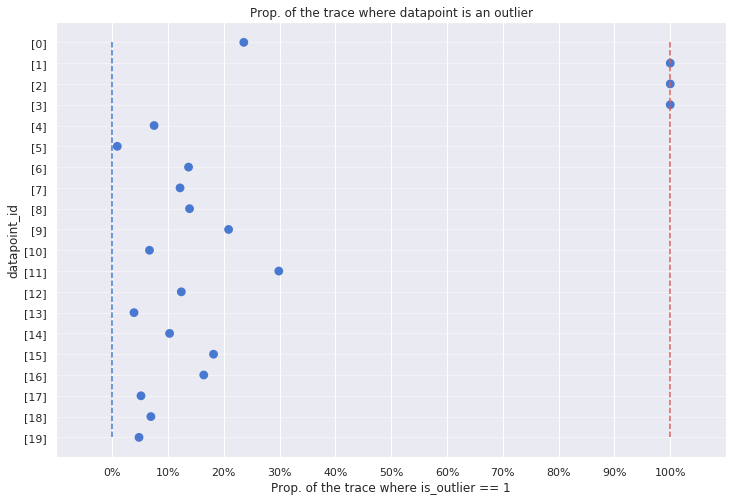

In [30]:
outlier_melt = pd.melt(pd.DataFrame(traces_signoise['is_outlier', -1000:],
                                   columns=['[{}]'.format(int(d)) for d in dfhoggs.index]),
                      var_name='datapoint_id', value_name='is_outlier')
ax0 = sns.pointplot(y='datapoint_id', x='is_outlier', data=outlier_melt,
                   kind='point', join=False, ci=None, size=4, aspect=2)

_ = ax0.vlines([0,1], 0, 19, ['b','r'], '--')

_ = ax0.set_xlim((-0.1,1.1))
_ = ax0.set_xticks(np.arange(0, 1.1, 0.1))
_ = ax0.set_xticklabels(['{:.0%}'.format(t) for t in np.arange(0,1.1,0.1)])

_ = ax0.yaxis.grid(True, linestyle='-', which='major', color='w', alpha=0.4)
_ = ax0.set_title('Prop. of the trace where datapoint is an outlier')
_ = ax0.set_xlabel('Prop. of the trace where is_outlier == 1')